In [ ]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
!unzip -q /content/kvasir-seg.zip

In [ ]:
# Load the necessary libraries
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import segmentation_models_pytorch as smp
import torch.optim as optim
import poutyne as pyt
from poutyne.framework.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# Define the dataset path
dataset_path = '/content/Kvasir-SEG/'

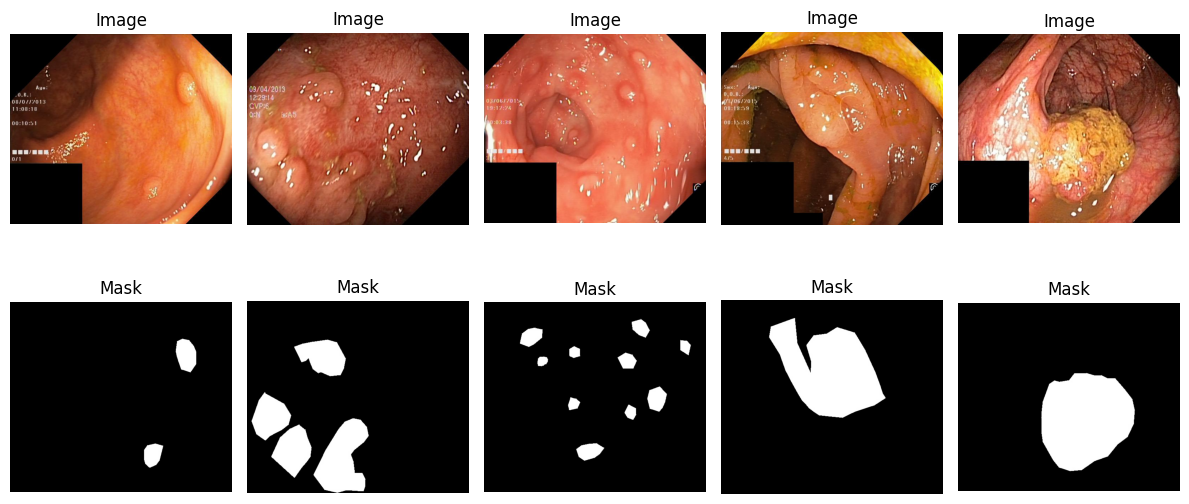

In [ ]:
# Sample some images for EDA
sample_images = []
sample_labels = []
sample_count = 5  # You can adjust this as needed

# Get a list of image filenames
image_filenames = os.listdir(os.path.join(dataset_path, 'images'))

# Randomly select and display sample images
import random
random.seed(42)  # For reproducibility
selected_images = random.sample(image_filenames, sample_count)

for image_filename in selected_images:
    # Load the image
    image_path = os.path.join(dataset_path, 'images', image_filename)
    label_path = os.path.join(dataset_path, 'masks', image_filename)

    image = cv2.imread(image_path)
    label = cv2.imread(label_path)

    # Append to the sample lists
    sample_images.append(image)
    sample_labels.append(label)

# Display sample images and labels
plt.figure(figsize=(12, 6))
for i in range(sample_count):
    plt.subplot(2, sample_count, i + 1)
    plt.imshow(cv2.cvtColor(sample_images[i], cv2.COLOR_BGR2RGB))
    plt.title('Image')
    plt.axis('off')

    plt.subplot(2, sample_count, i + sample_count + 1)
    plt.imshow(cv2.cvtColor(sample_labels[i], cv2.COLOR_BGR2RGB))
    plt.title('Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Define a dataset class for segmentation
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        mask = Image.open(self.mask_paths[idx])

        # Convert mask to a single channel mask if it's not already
        if mask.mode != 'L':
            mask = mask.convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [ ]:
# Get a list of image filenames
image_filenames = os.listdir(os.path.join(dataset_path, 'images'))

# Shuffle the list for random splitting
random.shuffle(image_filenames)

# Define the number of samples for each split
train_size = 900
val_size = 50
test_size = 50

# Split the dataset
train_images = image_filenames[:train_size]
val_images = image_filenames[train_size:train_size + val_size]
test_images = image_filenames[train_size + val_size:train_size + val_size + test_size]

# Print the sizes of each split
print(f"Train set size: {len(train_images)}")
print(f"Validation set size: {len(val_images)}")
print(f"Test set size: {len(test_images)}")

Train set size: 900
Validation set size: 50
Test set size: 50


In [ ]:
# Create paths to images and masks
images_df = os.path.join(dataset_path, 'images')
masks_df = os.path.join(dataset_path, 'masks')

image_paths = sorted([os.path.join(images_df, img) for img in os.listdir(images_df)])
mask_paths = sorted([os.path.join(masks_df, mask) for mask in os.listdir(masks_df)])

# Split the dataset into train, validation, and test sets
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

transform = transforms.Compose([transforms.Resize((256, 256)),
                                transforms.ToTensor()])

batch_size = 16

# Create dataset instances and data loaders
train_dataset = SegmentationDataset(X_train, y_train, transform=transform)
val_dataset = SegmentationDataset(X_val, y_val, transform=transform)
test_dataset = SegmentationDataset(X_test, y_test, transform=transform)

# Use CUDA to leverage the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# Define Unet++ model with a smaller encoder (ResNet18)
model = smp.UnetPlusPlus(encoder_name="resnet18", encoder_weights="imagenet", in_channels=3, classes=1)

# Define loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
metrics = ['iou', 'dice']

In [ ]:
# Define a directory to save checkpoints
checkpoint_dir = '/content/checkpoints/'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define a Poutyne model
poutyne_model = pyt.Model(model, optimizer, loss_fn).to(device)

callbacks = [
    ModelCheckpoint("best_model.pth", monitor="val_loss", save_best_only=True),
    EarlyStopping(monitor="val_loss", patience=10)
]

# Train the model
num_epochs = 20  # Adjust the number of epochs as needed
history = poutyne_model.fit_generator(train_loader, val_loader, epochs=num_epochs, callbacks=callbacks)

Epoch:  1/20 Train steps: 50 Val steps: 7 28.16s loss: 0.458672 val_loss: 0.334782
Epoch:  2/20 Train steps: 50 Val steps: 7 26.76s loss: 0.265701 val_loss: 0.240139
Epoch:  3/20 Train steps: 50 Val steps: 7 27.08s loss: 0.197655 val_loss: 0.206291
Epoch:  4/20 Train steps: 50 Val steps: 7 26.83s loss: 0.157126 val_loss: 0.193297
Epoch:  5/20 Train steps: 50 Val steps: 7 26.79s loss: 0.128224 val_loss: 0.166924
Epoch:  6/20 Train steps: 50 Val steps: 7 26.88s loss: 0.110292 val_loss: 0.174750
Epoch:  7/20 Train steps: 50 Val steps: 7 26.88s loss: 0.096119 val_loss: 0.165027
Epoch:  8/20 Train steps: 50 Val steps: 7 26.78s loss: 0.084910 val_loss: 0.151804
Epoch:  9/20 Train steps: 50 Val steps: 7 26.76s loss: 0.073214 val_loss: 0.145473
Epoch: 10/20 Train steps: 50 Val steps: 7 26.85s loss: 0.064620 val_loss: 0.136361
Epoch: 11/20 Train steps: 50 Val steps: 7 26.82s loss: 0.058704 val_loss: 0.139939
Epoch: 12/20 Train steps: 50 Val steps: 7 26.87s loss: 0.055291 val_loss: 0.145008
Epoc

In [ ]:
# Define functions to calculate IoU and Dice metrics
def calculate_iou(y_true, y_pred):
    # Convert tensors to byte data type
    y_true = y_true.byte()
    y_pred = y_pred.byte()

    intersection = (y_true & y_pred).sum()
    union = (y_true | y_pred).sum()
    iou = (intersection.float() + 1e-6) / (union.float() + 1e-6)
    return iou.item()

def calculate_dice(y_true, y_pred):
    # Convert tensors to byte data type
    y_true = y_true.byte()
    y_pred = y_pred.byte()

    intersection = (y_true & y_pred).sum()
    dice = (2.0 * intersection.float() + 1e-6) / (y_true.sum().float() + y_pred.sum().float() + 1e-6)
    return dice.item()

# Define a function to evaluate the model
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    iou_scores = []
    dice_scores = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            predictions = (outputs > 0.5).float()

            iou_batch = []
            dice_batch = []

            for i in range(len(inputs)):
                iou = calculate_iou(targets[i], predictions[i])
                dice = calculate_dice(targets[i], predictions[i])
                iou_batch.append(iou)
                dice_batch.append(dice)

            iou_scores.extend(iou_batch)
            dice_scores.extend(dice_batch)

    model.train()  # Set the model back to training mode

    avg_iou = np.mean(iou_scores)
    avg_dice = np.mean(dice_scores)

    return avg_iou, avg_dice

In [ ]:
model = model.to(device)
inputs = inputs.to(device)

# Evaluate the model on the test dataset
iou, dice = evaluate_model(model, test_loader)
print(f"IoU: {iou}, Dice: {dice}")

# Define a function to plot images with masks
def plot_images_with_masks(images, masks, predictions):
    num_samples = len(images)
    fig, axes = plt.subplots(nrows=num_samples, ncols=3, figsize=(12, 4*num_samples))

    for i in range(num_samples):
        axes[i, 0].imshow(images[i].permute(1, 2, 0))  # Display the test image
        axes[i, 0].set_title('Test Image')

        axes[i, 1].imshow(masks[i].squeeze(), cmap='gray')  # Display the ground truth mask
        axes[i, 1].set_title('Ground Truth Mask')

        axes[i, 2].imshow(predictions[i].squeeze(), cmap='gray')  # Display the predicted mask
        axes[i, 2].set_title('Predicted Mask')

    plt.tight_layout()
    plt.show()

# Load a batch of test data and make predictions
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    predictions = (outputs > 0.5).float()
    break  # Break after processing one batch

# Plot the images and masks
plot_images_with_masks(inputs.cpu(), targets.cpu(), predictions.cpu())

Output hidden; open in https://colab.research.google.com to view.